In [1]:
!git clone https://github.com/grayfactory/Toxicity-Under-Context-Detect.git
%cd Toxicity-Under-Context-Detect/
!ls

Cloning into 'Toxicity-Under-Context-Detect'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 41 (delta 16), reused 35 (delta 10), pack-reused 0
Unpacking objects: 100% (41/41), done.
/content/Toxicity-Under-Context-Detect
 BentoML.ipynb
 data
 Electra_with_pair_Sentence_Training_Eval.ipynb
'GTP-neo-fine-tuning(parents-text).ipynb'
'GTP-neo-fine-tuning(toxic-text).ipynb'
 Inference_Time.ipynb
 Preprocessing_data_and_prepare4training.ipynb
 README.md
 utils


In [2]:
!pip install transformers
!pip install datasets

from IPython.display import clear_output 

from transformers import (ElectraTokenizer, ElectraForSequenceClassification,
                          AdamW, get_linear_schedule_with_warmup)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F

from sklearn.model_selection import StratifiedShuffleSplit

from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
from pathlib import Path
import random

from utils._utils import MyConfig, plot_confusion_matrix, plot_history
from utils.model import (tokenize_segmented_text, TOXICDataset, 
                         f1_score_model, AverageMeter, 
                         train_epoch, eval_model, model_score, EarlyStopping)


clear_output()

In [3]:
# for model save
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [4]:
!ln -s /content/gdrive/My\ Drive/toxic_nlp /toxic_nlp
!ls /toxic_nlp

 BentoML.ipynb
 BERT_dynamic_quantiztion_tutorial.ipynb
'Copy of Electra_with_pair_Sentence_Training_Eval.ipynb'
 dataset
 Electra-model
 Electra-model-save
 Electra_with_pair_sentence.ipynb
 Electra_with_pair_sentence_trained_generated_dataset.ipynb
 Electra_with_pair_sentence_trained_vanilla_dataset.ipynb
 Electra_with_pair_Sentence_Training_Eval.ipynb
 fine-tuneWith_transformer_API_tutorial.ipynb
 gpt-neo-checkpoints
'GTP-neo-fine-tuning(parents-text).ipynb'
'GTP-neo-fine-tuning(toxic-text).ipynb'
 Hope-speech-tutorial.ipynb
 Inference_Time.ipynb
 ktrain.ipynb
 Preprocessing_data_and_prepare4training.ipynb
 preprocessing_datasets.ipynb
 pytorch_tutorial.ipynb
 toxic_nlp
 toxic_v1.ipynb
 toxic_v2.ipynb


# Set configs

In [5]:
configs = MyConfig({
    'path_drive' : Path('/toxic_nlp'),
    'path_colab_data' : Path('./data'),
    'seeds' : 42,
    'model_to_use' : 'google/electra-small-discriminator',
    'tokenizer_to_use' : 'google/electra-small-discriminator',
    'model_ckp_dir' : Path('/toxic_nlp/Electra-model-save')
})
configs.list_csv = [f for f in Path(configs.path_drive /'dataset').glob('*.csv')]

if configs.seeds:
  random.seed(configs.seeds)
  np.random.seed(configs.seeds)
  torch.manual_seed(configs.seeds)


# 학습에 사용할 CPU나 GPU 장치를 얻습니다.
if torch.cuda.is_available():
  configs.device = "cuda"
else: configs.device="cpu"

print("Using {} device".format(configs.device))

configs

Using cuda device


{'device': 'cuda',
 'list_csv': [PosixPath('/toxic_nlp/dataset/gc_clean.csv'),
  PosixPath('/toxic_nlp/dataset/gc_clean_ner.csv'),
  PosixPath('/toxic_nlp/dataset/gab_reddit.csv'),
  PosixPath('/toxic_nlp/dataset/gab_reddit_ner.csv'),
  PosixPath('/toxic_nlp/dataset/parent_gen_data.csv'),
  PosixPath('/toxic_nlp/dataset/text_gen_data.csv'),
  PosixPath('/toxic_nlp/dataset/parent_gen_data_v2.csv'),
  PosixPath('/toxic_nlp/dataset/text_gen_data_v2.csv'),
  PosixPath('/toxic_nlp/dataset/generated_dataset.csv'),
  PosixPath('/toxic_nlp/dataset/tweet.csv'),
  PosixPath('/toxic_nlp/dataset/hate_speech18.csv'),
  PosixPath('/toxic_nlp/dataset/jig_train.csv'),
  PosixPath('/toxic_nlp/dataset/merged.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v1_train.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v1_test.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v1_gan_merged.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v2_gan_merged.csv')],
 'model_ckp_dir': PosixPath('/toxic_nlp/Electra-model-save'),
 'model_to_us

In [6]:
def get_data_csv_path(configs, condition):
  condition = condition
  return [f for f in configs.list_csv if f'{condition}' in str(f)][0]

In [7]:
df_train = pd.read_csv( get_data_csv_path(configs,'exp_v1_train.csv'), index_col=0)
df_test = pd.read_csv( get_data_csv_path(configs, 'exp_v1_test.csv'), index_col=0)



/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df_train.label.value_counts() / df_train.shape[0]

0    0.845665
1    0.154335
Name: label, dtype: float64

In [9]:
df_train

,index,parent,text,label,parent_gen,text_gen,src
0,23973,RT _Sailer: Speaking of witchcraft (as Vox doe...,call your nigger witch doctor white boy..maybe...,1,RT _Sailer: Speaking of witchcraft (as Vox do...,call your nigger lover a faggot,0
1,14616,"Robert, how is your moral fagging going? When ...",Speaking ones mind.. like how evil the Altrigh...,1,"Robert, how is your moral fagging going? If y...",suck a nigger cock and expect a nigger cock i...,0
2,2487,BTW do we need the co-ords at the top right an...,"Ah, so that's what goes in there! The ones at ...",0,BTW do we intend to make the edit war a non-c...,"Ah, so that's what goes in there...",0
3,7672,What time is meant? Coming together is apparen...,in the Act of Kreva has a Latin word 'aplicare...,0,What time is meant? Coming together and getti...,in the Act of Kreva has a Latin word 'aplicar...,0
4,8157,lol! one diff is sufficient to over-write the ...,I said why I restored and you did the same by ...,0,lol! one diff is sufficient touzzy. Faggot.,I said why I restored your edit in full. Howe...,0
...,...,...,...,...,...,...,...
196406,59555,NaN,that special moments where you have everything...,0,NaN,NaN,3
196407,45371,NaN,kudos for being compliant :) itaxnirahisi,0,NaN,NaN,3
196408,31713,NaN,streetautopia attack bull game : do you really...,0,NaN,NaN,3
196409,48505,NaN,not to sound but has her looks to fall back on...,1,NaN,NaN,3


In [10]:
from sklearn.model_selection import train_test_split
# split test data first
# df_train = df_gan.copy()
# train, test = train_test_split(df_train, test_size=0.15, random_state=configs.seeds)
# print(f'train set shape : {train.shape}\ntest set shape : {test.shape}')
# # train.head()

# split train & validation set
df_train = df_train.reset_index()
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=configs.seeds)

for train_idx, val_idx in split.split(df_train, df_train['label'] ):
    train, val = df_train.loc[train_idx], df_train.loc[val_idx]

# X, y 만 keep
X_train, y_train = train[['text','parent']], train['label']
X_val, y_val = val[['text','parent']], val['label']

# 도메인간 정확률 비교를 위해 y_src 정보를 keep
X_test, y_test, y_src = df_test[['text','parent']], df_test['label'], df_test[['index','src','label']]

print('\nratio of toxic / non toxic \n',y_train.value_counts() / len(y_train),'\n',
      y_val.value_counts() / len(y_val),
      '\n',y_test.value_counts() / len(y_test))
y_test.value_counts() / len(y_test)


ratio of toxic / non toxic 
 0    0.845667
1    0.154333
Name: label, dtype: float64 
 0    0.845658
1    0.154342
Name: label, dtype: float64 
 0    0.845681
1    0.154319
Name: label, dtype: float64


0    0.845681
1    0.154319
Name: label, dtype: float64

In [11]:
# model_esc = ElectraForSequenceClassification.from_pretrained(configs.model_to_use).to(configs.device)
# tokenizer = ElectraTokenizer.from_pretrained(configs.tokenizer_to_use)

model_esc = ElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator').to(configs.device)
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
X_train.shape

(157128, 2)

In [13]:
# configs.max_len = 256
configs.max_len = 128
configs.batch_size = 128
configs.EPOCHS = 10

configs.optimizer = AdamW(model_esc.parameters(), lr=1e-5)
configs.loss_fn = nn.CrossEntropyLoss().to(configs.device)

# model save path set
configs.model_save_dir = configs.path_drive / f'Electra-model-save/electra-ori-model.pt'

configs.early_stop_patience = 4
configs.early_stop_delta = 0.01
# init early stopping
early_stopping = EarlyStopping(patience = configs.early_stop_patience, 
                               delta=configs.early_stop_delta,
                               verbose = True, 
                               path=configs.model_save_dir)

# load dataset
train_dataset = TOXICDataset(X_train, y_train, tokenizer, configs.max_len)
train_loader = DataLoader(train_dataset, batch_size=configs.batch_size, shuffle=True)

val_dataset = TOXICDataset(X_val, y_val, tokenizer, configs.max_len)
val_loader = DataLoader(val_dataset, batch_size=configs.batch_size, shuffle=True)

configs.total_steps = len(train_loader) * configs.EPOCHS
configs.scheduler = get_linear_schedule_with_warmup(
                    configs.optimizer,
                    num_warmup_steps=0,
                    num_training_steps=configs.total_steps
                )


configs

{'EPOCHS': 10,
 'batch_size': 128,
 'device': 'cuda',
 'early_stop_delta': 0.01,
 'early_stop_patience': 4,
 'list_csv': [PosixPath('/toxic_nlp/dataset/gc_clean.csv'),
  PosixPath('/toxic_nlp/dataset/gc_clean_ner.csv'),
  PosixPath('/toxic_nlp/dataset/gab_reddit.csv'),
  PosixPath('/toxic_nlp/dataset/gab_reddit_ner.csv'),
  PosixPath('/toxic_nlp/dataset/parent_gen_data.csv'),
  PosixPath('/toxic_nlp/dataset/text_gen_data.csv'),
  PosixPath('/toxic_nlp/dataset/parent_gen_data_v2.csv'),
  PosixPath('/toxic_nlp/dataset/text_gen_data_v2.csv'),
  PosixPath('/toxic_nlp/dataset/generated_dataset.csv'),
  PosixPath('/toxic_nlp/dataset/tweet.csv'),
  PosixPath('/toxic_nlp/dataset/hate_speech18.csv'),
  PosixPath('/toxic_nlp/dataset/jig_train.csv'),
  PosixPath('/toxic_nlp/dataset/merged.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v1_train.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v1_test.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v1_gan_merged.csv'),
  PosixPath('/toxic_nlp/dataset/exp_v2_gan_m

## Training Model

  0%|          | 0/1228 [00:00<?, ?it/s]

  0%|          | 0/307 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.136842).  Saving model ...
Train Loss 0.20592 accuracy 0.93398 f1 0.72116
Val Loss 0.13684 accuracy 0.94840 f1 0.83320



  0%|          | 0/1228 [00:00<?, ?it/s]

  0%|          | 0/307 [00:00<?, ?it/s]

Validation loss decreased (0.136842 --> 0.125493).  Saving model ...
Train Loss 0.12659 accuracy 0.95359 f1 0.83947
Val Loss 0.12549 accuracy 0.95415 f1 0.84010



  0%|          | 0/1228 [00:00<?, ?it/s]

  0%|          | 0/307 [00:00<?, ?it/s]

EarlyStopping counter: 1 out of 4
Train Loss 0.11642 accuracy 0.95649 f1 0.84951
Val Loss 0.11776 accuracy 0.95596 f1 0.84611



  0%|          | 0/1228 [00:00<?, ?it/s]

  0%|          | 0/307 [00:00<?, ?it/s]

EarlyStopping counter: 2 out of 4
Train Loss 0.10820 accuracy 0.95937 f1 0.86053
Val Loss 0.11808 accuracy 0.95553 f1 0.85190



  0%|          | 0/1228 [00:00<?, ?it/s]

  0%|          | 0/307 [00:00<?, ?it/s]

EarlyStopping counter: 3 out of 4
Train Loss 0.10208 accuracy 0.96131 f1 0.86791
Val Loss 0.11769 accuracy 0.95520 f1 0.85352



  0%|          | 0/1228 [00:00<?, ?it/s]

  0%|          | 0/307 [00:00<?, ?it/s]

EarlyStopping counter: 4 out of 4
Early stopping


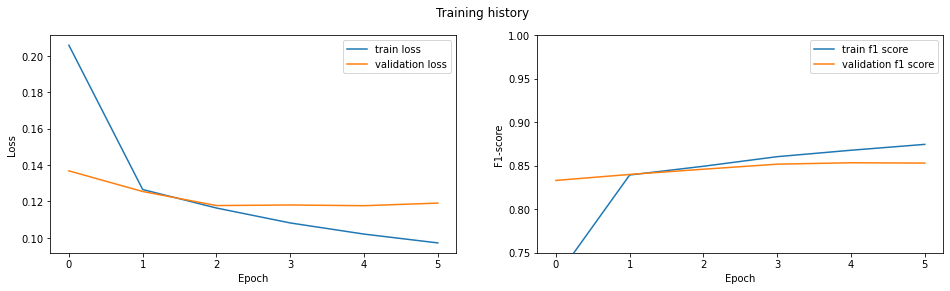

In [14]:
from collections import defaultdict

history = defaultdict(list)

# lets training
for epoch in range(configs.EPOCHS):

  train_acc, train_loss, f1_train = train_epoch(
      model_esc,
      train_loader,
      configs.loss_fn,
      configs.optimizer,
      configs.device,
      configs.scheduler,
      len(train_dataset)
  )

  val_acc, val_loss, f1_val = eval_model(
      model_esc,
      val_loader,
      configs.loss_fn,
      configs.device,
      len(val_dataset)
  )

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['train_f1'].append(f1_train.avg.item())
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  history['val_f1'].append(f1_val.avg.item())

  early_stopping(val_loss, model_esc)

  if early_stopping.early_stop:
    print('Early stopping')
    break

  print(f'Train Loss {train_loss:.5f} accuracy {train_acc:.5f} f1 {f1_train.avg.item():.5f}')
  print(f'Val Loss {val_loss:.5f} accuracy {val_acc:.5f} f1 {f1_val.avg.item():.5f}')
  print()

plot_history(history)

## Evaluation with Test set

In [15]:
X_test
y_test.value_counts()
y_src.src.value_counts()

1    23865
3     4795
0     4464
2     1538
Name: src, dtype: int64

In [16]:
# incase evaluation with uploaded model
# ori-model = gan data 없는 버전
# remodel = gan data를 합쳐서 training 한 버전
configs.model_save_dir = configs.model_ckp_dir / 'electra-ori-model.pt'

# fine-tuning model with condition!
model_generated = ElectraForSequenceClassification.from_pretrained(configs.model_to_use).to(configs.device)
model_generated.load_state_dict(torch.load(configs.model_save_dir))

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

<All keys matched successfully>

In [17]:
# load test set without shuffle
test_dataset = TOXICDataset(X_test, y_test, tokenizer, configs.max_len)
test_loader = DataLoader(test_dataset, batch_size=configs.batch_size)
len(test_dataset)

34662

In [18]:
from sklearn.metrics import f1_score, roc_auc_score
from itertools import chain

y_pred, y_true, y_prob = model_score(model_esc, test_loader, configs)

predicted = list(chain.from_iterable(y_pred))
true_label = list(chain.from_iterable(y_true))
proba = list(chain.from_iterable(y_prob))



  0%|          | 0/271 [00:00<?, ?it/s]

Electra train with - all source - Condition
Results f1 : 0.8455, roc auc : 0.9802


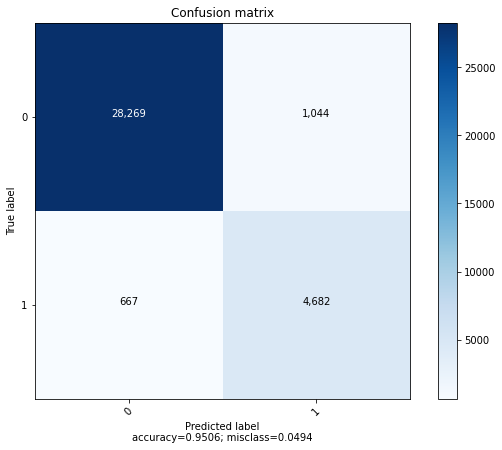

In [19]:
from sklearn.metrics import confusion_matrix

f1, roc_auc = f1_score(true_label, predicted), roc_auc_score(true_label, proba)

print(f'Electra train with - all source - Condition\nResults f1 : {f1:.4f}, roc auc : {roc_auc:.4f}')
cm = confusion_matrix(true_label, predicted)
target_name = [0,1]

plot_confusion_matrix(cm, target_name, normalize=False)

In [20]:
y_src['y_pred_label'] = predicted
y_src['y_pred_prob'] = proba

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Electra predicted subset: gab_reddit-Condition
Results f1 : 0.9561, roc auc : 0.9835


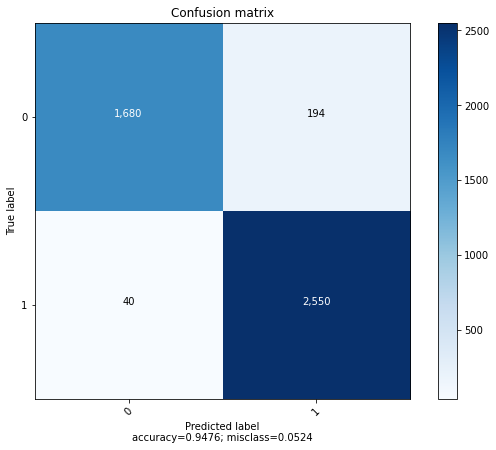

Electra predicted subset: jig-Condition
Results f1 : 0.7986, roc auc : 0.9788


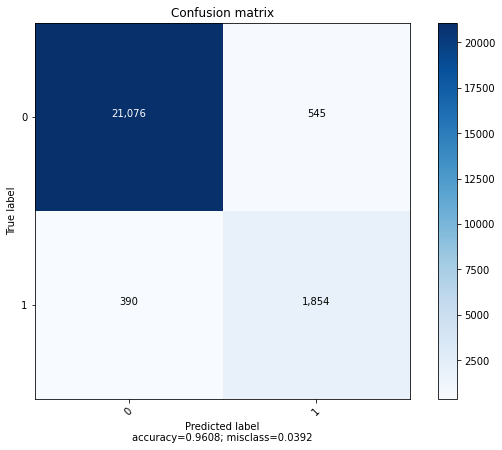

Electra predicted subset: tweet-Condition
Results f1 : 0.4579, roc auc : 0.8546


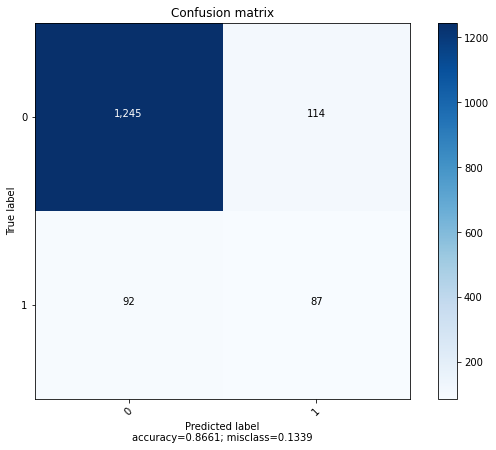

Electra predicted subset: stormfront-Condition
Results f1 : 0.5320, roc auc : 0.9192


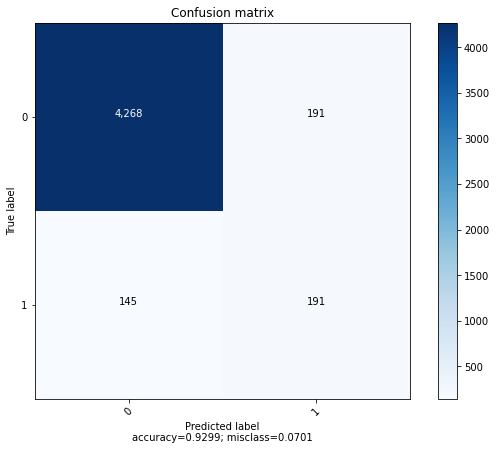

In [21]:
source = ['gab_reddit','jig','tweet','stormfront']

for i, name in enumerate(source):
  sub_true_label = y_src[y_src.src==i]['label']
  sub_predicted = y_src[y_src.src==i]['y_pred_label']
  sub_proba = y_src[y_src.src==i]['y_pred_prob']
  f1, roc_auc = f1_score(sub_true_label, sub_predicted), roc_auc_score(sub_true_label, sub_proba)
  print(f'Electra predicted subset: {name}-Condition\nResults f1 : {f1:.4f}, roc auc : {roc_auc:.4f}')
  cm = confusion_matrix(sub_true_label, sub_predicted)
  target_name = [0,1]

  plot_confusion_matrix(cm, target_name, normalize=False)

## Benchmark (or) Generalization Test. with Kaggle Toxic Dataset
- context가 있는 Toxic detaction benchmark dataset은 존재하지 않기 때문에, kaggle toxic data에서 성능을 평가해보자.
- kaggle toxic data는 context가 없다.

In [ ]:
configs

{'EPOCHS': 10,
 'batch_size': 128,
 'device': 'cuda',
 'early_stop_delta': 0.01,
 'early_stop_patience': 4,
 'loss_fn': CrossEntropyLoss(),
 'max_len': 256,
 'model_ckp_dir': PosixPath('/content/gdrive/MyDrive/toxic_nlp/Electra-model-save'),
 'model_save_dir': PosixPath('/content/gdrive/MyDrive/toxic_nlp/Electra-model-save/electra-all-merged.pt'),
 'model_to_use': 'google/electra-small-discriminator',
 'optimizer': AdamW (
 Parameter Group 0
     betas: (0.9, 0.999)
     correct_bias: True
     eps: 1e-06
     initial_lr: 1e-05
     lr: 1e-05
     weight_decay: 0.0
 ),
 'path': {'list_csv': [PosixPath('data/jig_all.csv'),
   PosixPath('data/combination-gan-ori.csv'),
   PosixPath('data/combination-ori-ori.csv'),
   PosixPath('data/combination-all-merged.csv'),
   PosixPath('data/combination-ori-gan.csv'),
   PosixPath('data/jig_test.csv'),
   PosixPath('data/combination-gan-gan.csv'),
   PosixPath('data/gc_clean.csv')],
  'path_colab_data': PosixPath('data'),
  'path_drive': PosixPath(

In [ ]:
df_jig = pd.read_csv(get_data_csv_path(configs, 'jig_all.csv'), index_col=0)
df_jig

,comment_text,parent,toxic
0,Thank you for understanding. I think very high...,NaN,0
1,:Dear god this site is horrible.,NaN,0
2,"""::: Somebody will invariably try to add Relig...",NaN,0
3,""" \n\n It says it right there that it IS a typ...",NaN,0
4,""" \n\n == Before adding a new product to the l...",NaN,0
...,...,...,...
127951,":Jerome, I see you never got around to this…! ...",NaN,0
127952,==Lucky bastard== \n http://wikimediafoundatio...,NaN,0
127953,==shame on you all!!!== \n\n You want to speak...,NaN,0
127954,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,NaN,1


In [ ]:
df_jig.toxic.value_counts()

0    115776
1     12180
Name: toxic, dtype: int64

In [ ]:
X_test = df_jig[['comment_text','parent']]
y_test = df_jig['toxic']
configs.model_save_dir

PosixPath('/content/gdrive/MyDrive/toxic_nlp/Electra-model-save/electra-all-merged.pt')

In [ ]:
configs

{'device': 'cuda',
 'model_ckp_dir': PosixPath('Toxicity-Under-Context-Detect/model_ckp'),
 'model_to_use': 'google/electra-small-discriminator',
 'path': {'list_csv': [PosixPath('data/jig_test.csv'),
   PosixPath('data/combination-gan-ori.csv'),
   PosixPath('data/jig_all.csv'),
   PosixPath('data/combination-ori-gan.csv'),
   PosixPath('data/combination-gan-gan.csv'),
   PosixPath('data/combination-all-merged.csv'),
   PosixPath('data/combination-ori-ori.csv'),
   PosixPath('data/gc_clean.csv')],
  'path_colab_data': PosixPath('data'),
  'path_drive': PosixPath('/content/gdrive/MyDrive/toxic_nlp')},
 'seeds': 42,
 'source': 'github',
 'tokenizer_to_use': 'google/electra-small-discriminator',
 'train_condition': 'ori-ori'}

In [ ]:
# incase evaluation with uploaded model
if configs.source == 'github':
  configs.model_save_dir = configs.model_ckp_dir / 'electra-generated-data-full-merged.pt'


?


In [ ]:
# fine-tuning model with condition!
model_generated = ElectraForSequenceClassification.from_pretrained(configs.model_to_use).to(configs.device)
model_generated.load_state_dict(torch.load(configs.model_save_dir))

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

<All keys matched successfully>

In [ ]:
# load test set without shuffle
test_dataset = TOXICDataset(X_test, y_test, tokenizer, configs.max_len)
test_loader = DataLoader(test_dataset, batch_size=configs.batch_size)
len(test_dataset)

127956

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from itertools import chain

y_pred, y_true, y_prob = model_score(model_generated, test_loader, configs)

predicted = list(chain.from_iterable(y_pred))
true_label = list(chain.from_iterable(y_true))
proba = list(chain.from_iterable(y_prob))

f1, roc_auc = f1_score(true_label, predicted), roc_auc_score(true_label, proba)

print(f'Electra train with - {configs.train_condition} - Condition\nResults f1 : {f1:.4f}, roc auc : {roc_auc:.4f}')


cm = confusion_matrix(true_label, predicted)
target_name = [0,1]

plot_confusion_matrix(cm, target_name, normalize=False)

NameError: ignored

Electra train with - all-merged - Condition
Results f1 : 0.4886, roc auc : 0.9020


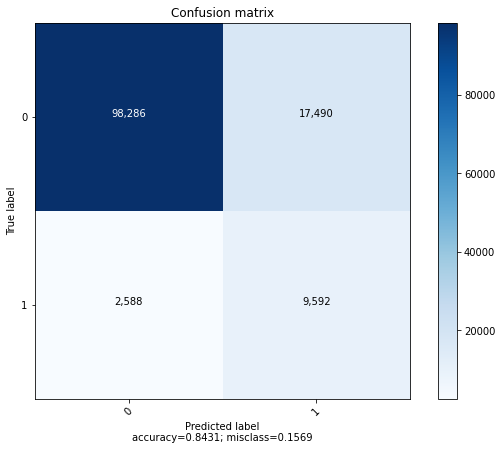

In [ ]:
from itertools import chain

predicted = list(chain.from_iterable(y_pred))
true_label = list(chain.from_iterable(y_true))
proba = list(chain.from_iterable(y_prob))

f1, roc_auc = f1_score(true_label, predicted), roc_auc_score(true_label, proba)

print(f'Electra train with - {configs.train_condition} - Condition\nResults f1 : {f1:.4f}, roc auc : {roc_auc:.4f}')


cm = confusion_matrix(true_label, predicted)
target_name = [0,1]

plot_confusion_matrix(cm, target_name, normalize=False)